# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.892485,False,0.251622
1,0.313720,False,-0.809534
2,-2.144251,False,-1.008489
3,-0.063382,False,-2.079530
4,-0.356550,True,5.562669
...,...,...,...
995,0.145843,True,5.385372
996,-0.583821,False,-0.747747
997,1.793261,True,5.878069
998,-0.919091,False,1.091455


<Axes: xlabel='v0'>

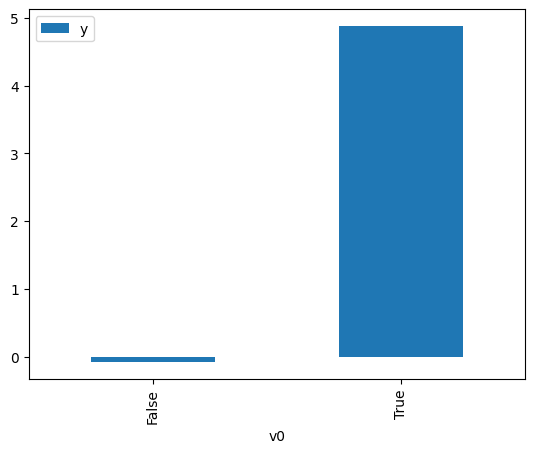

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

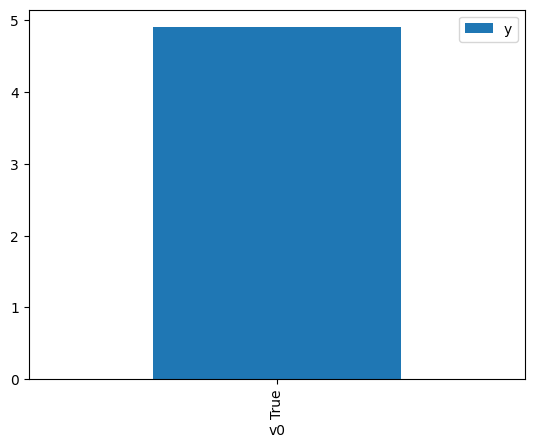

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.211940,False,0.117004,0.558166,1.791581
1,-1.804408,False,-0.065812,0.949930,1.052709
2,0.560533,False,-0.022130,0.253416,3.946074
3,-1.934202,False,0.430601,0.959448,1.042266
4,0.322838,False,-1.800416,0.337135,2.966168
...,...,...,...,...,...
995,0.976071,False,-0.916422,0.143389,6.974025
996,-0.979430,False,-0.180520,0.823384,1.214501
997,-0.095468,False,1.990286,0.508892,1.965053
998,2.029787,False,0.153493,0.027117,36.876807


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.768363,True,3.981326,0.807532,1.238341
1,0.324087,True,3.051698,0.663339,1.507524
2,-1.853299,True,4.725540,0.046259,21.617506
3,-1.853299,True,4.725540,0.046259,21.617506
4,0.022911,True,5.263316,0.541362,1.847194
...,...,...,...,...,...
995,0.147616,True,3.245919,0.593387,1.685241
996,0.427352,True,4.269321,0.701383,1.425754
997,0.751225,True,5.178883,0.802959,1.245393
998,1.069206,True,2.544247,0.874996,1.142863


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              5090.
Date:                Sat, 05 Aug 2023   Prob (F-statistic):                        0.00
Time:                        06:09:53   Log-Likelihood:                         -1445.3
No. Observations:                1000   AIC:                                      2895.
Df Residuals:                     998   BIC:                                      2904.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1381      0.031      4.414      0.000       0.077       0.200
x2             4.9189      0.050     97.473      0.000       4.820       5.018
==============================================================================
Omnibus:                        2.671   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                2.808
Skew:                          -0.035   Prob(JB):                        0.246
Kurtosis:                       3.250   Cond. No.                         1.70
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""